In [1]:
from streaming.models.inputs import SimulationMeasurements
from streaming.models import stream
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import cosmology
import read_clpt 
from scipy.optimize import curve_fit
import pickle

In [2]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')
from streaming.utils import plot_tools as pt


In [3]:
pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"
simulation = SimulationMeasurements(pdf_filename, tpcf_filename)

In [4]:
clpt_dir = '/cosma/home/dp004/dc-cues1/CLPT_GSRSD/'


## Create linear power spectrum, and compute linear growth

In [5]:
k_, power_ = np.loadtxt(clpt_dir + 'data/PL_z0.55.dat', unpack=True)

cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift = 0., transfer = 'CLASS')

In [6]:
k = np.logspace(-5, 2, 100)

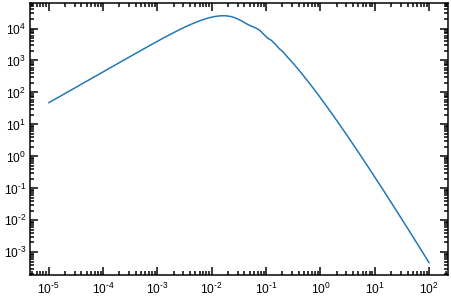

In [7]:
plt.loglog(k, Plin(k))

In [8]:
tosave = np.vstack((k, Plin(k))).T
np.savetxt(clpt_dir + 'data/linear_pow.txt', tosave)

In [9]:
bg = cosmology.background.PerturbationGrowth(cosmo)

linear_growth = bg.f1(a = 1)


/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: PerturbationGrowth is deprecated. Use RadiationDominated instead
  """Entry point for launching an IPython kernel.


In [10]:
r_clpt = read_clpt.r_binning()

In [11]:
r_fit_range = r_clpt > 10

def xi_clpt(r, f1, f2, fit_range = True):
    
    if fit_range:
        return read_clpt.tpcf_prediction(f1, f2, linear_growth)[r_fit_range]
    else:
        return read_clpt.tpcf_prediction(f1, f2, linear_growth)

In [12]:
# Fit
measured_tpcf =  simulation.tpcf.mean(r_clpt)     

popt, pcov = curve_fit(xi_clpt,r_clpt[r_fit_range], measured_tpcf[r_fit_range])

b1, b2, a = popt

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [13]:
b2**2

0.4619860761424609

In [14]:
b2

-0.6796955760798071

Text(0,0.5,'Ratio')

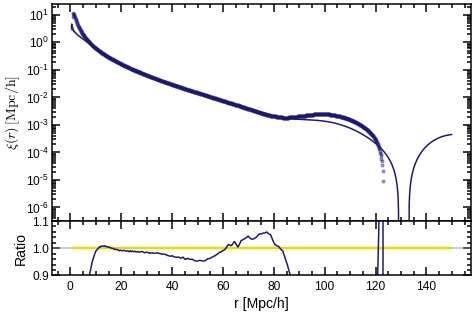

In [15]:
# Measure the real space correlation function w same binning
#plt.semilogy(r_clpt, measured_tpcf)
#plt.semilogy(r_clpt, xi_clpt(r_clpt, b1, b2, fit_range = False))


# --------------- Mean --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].semilogy(r_clpt, 
             measured_tpcf,
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             xi_clpt(r_clpt, b1, b2, fit_range = False),
            color = 'midnightblue')

axes[0].set_ylabel(r'$\xi(r) \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, xi_clpt(r_clpt, b1, b2, fit_range = False) / measured_tpcf, 
         color = 'midnightblue')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r'r [Mpc/h]')
axes[1].set_ylabel(r'Ratio')


In [16]:
# load clpt predictions
r_clpt, xi_clpt, v12_clpt, s12_par_clpt, s12_perp_clpt = read_clpt.weighted_perturbation_prediction(b1,
                                                                                    b2,linear_growth)

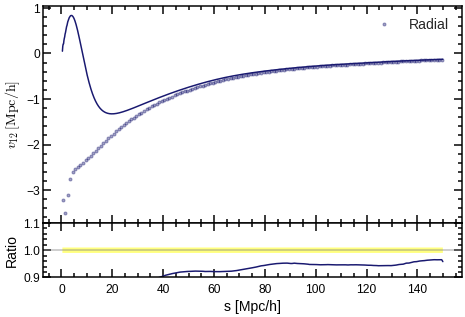

In [17]:
# --------------- Mean --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].errorbar(simulation.r, 
             simulation.m_10.mean(simulation.r),
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             v12_clpt,
            color = 'midnightblue')

axes[0].set_ylabel('$v_{12} \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, v12_clpt / simulation.m_10.mean(r_clpt), 
         color = 'midnightblue')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r's [Mpc/h]')
axes[1].set_ylabel(r'Ratio')
axes[0].legend(frameon=False)

In [18]:
np.where(r_clpt > 100)[0][0]

666

In [28]:
simulation.c_20.mean(100.)

array(21.49203655)

In [19]:
# compute shift: sigma_fog
bin_100 = np.where(r_clpt > 100)[0][0]
sigma_fog_parallel = s12_par_clpt[bin_100] - simulation.c_20.mean(r_clpt[bin_100])
sigma_fog_perpendicular = s12_perp_clpt[bin_100] - simulation.c_02.mean(r_clpt[bin_100])

sigma_fog = -np.mean((sigma_fog_parallel, sigma_fog_perpendicular))

In [20]:
sigma_fog

-14.607859968801487

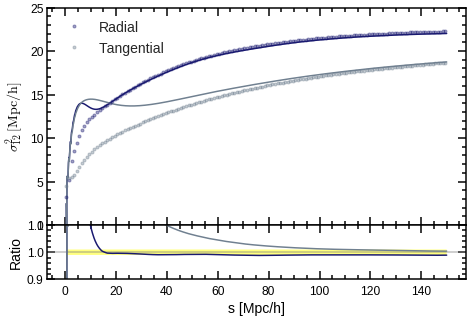

In [21]:
# --------------- STD --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].errorbar(simulation.r, 
                simulation.c_20.mean(simulation.r),
                 marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             s12_par_clpt + sigma_fog,
            color = 'midnightblue')

axes[0].errorbar(simulation.r, 
             simulation.c_02.mean(simulation.r),
            marker = 'o', linestyle = '',
             color = 'slategray', label = 'Tangential', alpha = 0.4)
axes[0].plot(r_clpt, 
             s12_perp_clpt + sigma_fog,
            color = 'slategray')

axes[0].set_ylabel('$\sigma_{12}^2 \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, (s12_par_clpt +sigma_fog) / simulation.c_20.mean(r_clpt), 
         color = 'midnightblue')

axes[1].plot(r_clpt, (s12_perp_clpt +sigma_fog) / simulation.c_02.mean(r_clpt), 
         color = 'slategray')

axes[1].set_ylim(0.9,1.1)
axes[0].set_ylim(0.,25.)

axes[1].set_xlabel(r's [Mpc/h]')
axes[1].set_ylabel(r'Ratio')
axes[0].legend(frameon=False)

In [22]:
clpt_params = {'b1': b1,
                 'b2': b2,
                'sigma_fog': sigma_fog,
              'linear_growth':linear_growth}

In [23]:
with open('clpt_params.pkl', 'wb') as f:
    pickle.dump(clpt_params, f)